# [Exploration 17] Movielens 영화 SBR 

Movielens 1M Dataset을 기반으로 Session Based Recommendation(SBR)시스템 제작

---

## 프로젝트 목표
---
- 이미지 해상도에 대한 이해
- Bicubic Interpolation, SRGAN으로 실험 후 비교

## 프로젝트 설명
---
1. 데이터의 전처리
    - 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
    - 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.
2. 미니 배치의 구성
    - 실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
    - 단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.
3. 모델 구성
    - 이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.
4. 모델 학습
    - 다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.
5. 모델 테스트 
    - 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

## 0. 데이터 불러오기

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import datetime as dt
from dateutil import tz
from pathlib import Path
import os
import random

import pandas as pd
import warnings
warnings.filterwarnings('ignore')


import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## 1. 데이터 전처리
- 위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
- 특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

- Movielens 데이터 셋은 session id 대신 user id가 있습니다.
- 한 user id당 몇 개의 데이터를 갖고 있는지 확인하겠습니다.

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [7]:
session_length.min(), session_length.max()

(20, 2314)

- quantile = 소득구간, 변위치 등 구간을 나타내는 개념 
- parameter = 0.999 이면 전체 데이터의 0.999%를 확인할 수 있습니다.

In [8]:
session_length.quantile(0.999)

1343.181000000005

In [9]:
session_length.quantile(0.5)

96.0

- 세션 길이를 시각화해서 이상치가 있는지 확인해보겠습니다.

In [10]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

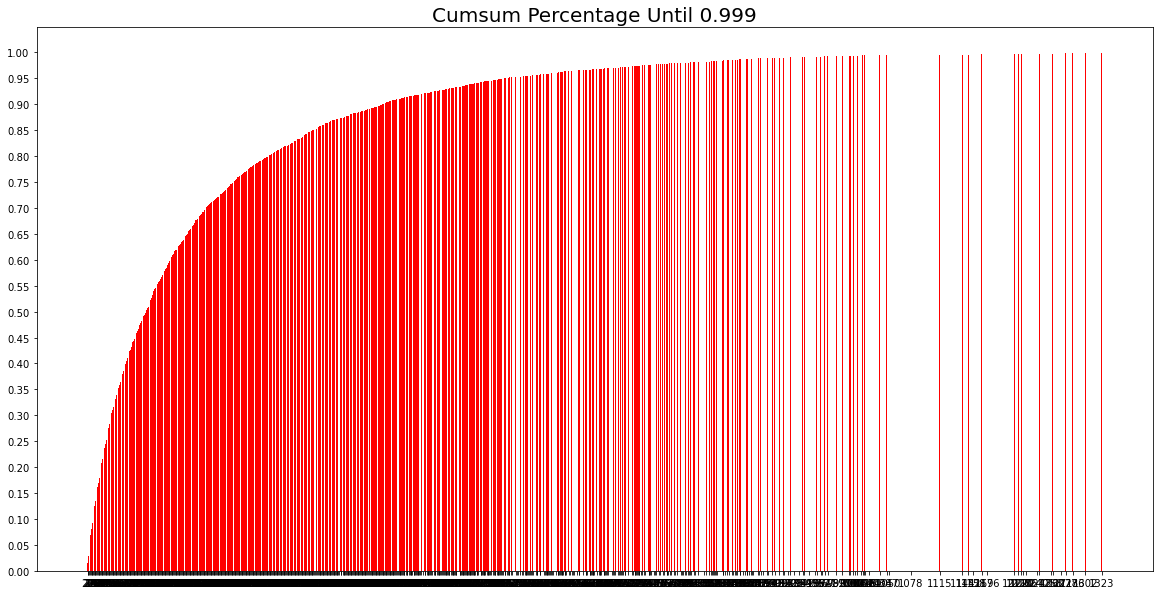

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

- 'Time' = session time
- UTC time 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

In [12]:
oldest, latest = data['Time'].min(), data['Time'].max()
oldest, latest

(956703932, 1046454590)

- timestamp를 time_struct 타입으로 변환합니다.

In [13]:
import time

tm_old = time.gmtime(oldest)
print(tm_old)

tm_latest = time.gmtime(latest)
print(tm_latest)

time.struct_time(tm_year=2000, tm_mon=4, tm_mday=25, tm_hour=23, tm_min=5, tm_sec=32, tm_wday=1, tm_yday=116, tm_isdst=0)
time.struct_time(tm_year=2003, tm_mon=2, tm_mday=28, tm_hour=17, tm_min=49, tm_sec=50, tm_wday=4, tm_yday=59, tm_isdst=0)


**2000년 4월 25일부터 2003년 2월 28일까지의 데이터가 있습니다.**
- session(user_id)별로 다음에 볼 영화를 예측하고자 합니다.
- 영화를 추천(예측)하는 시스템은 사용자의 평가(Rating)가 중요하다고 판단됩니다.
- 평가(Rating) 분포를 확인하겠습니다.

<AxesSubplot:xlabel='Rating', ylabel='Density'>

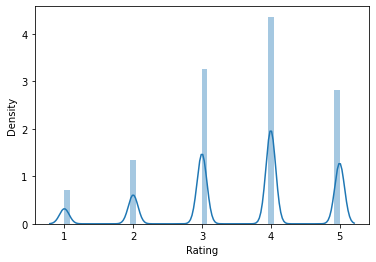

In [16]:
sns.distplot(data['Rating'])

**1, 2점 데이터의 분포가 적기 때문에 3점 이상의 데이터만 취급하겠습니다.**

In [24]:
rate = data[data['Rating']>=3]
rate

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 836478개의 데이터가 남는 것을 확인했습니다. 
- 평점이 낮은 영화는 추천이 되어도 좋은 추천 시스템이 아니라고 생각하기 때문에 해당 데이터는 삭제하도록 하겠습니다.

In [27]:
data[data['Rating']>=3]

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [28]:
data = data[data['Rating']>=3]
len(data)

836478

## 2. 미니 배치의 구성
- Movielens 데이터셋에서 session(Time)은 리뷰를 남긴 시간으로 영화 추천과 관련이 깊지 않다고 생각합니다.
- 때문에 세션 기준으로 데이터셋을 구성하지 않고 무작위로 섞어 session id(UserId)의 분포가 각 데이터셋마다 고르도록 설정하도록 하겠습니다.

In [29]:
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


In [34]:
#determinism seed
#random
SEED = 2021

# random seed 
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [35]:
set_seeds()

In [36]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=2021)
train, valid = train_test_split(train, test_size=0.2, random_state=2021)
print(len(train), len(valid), len(test))

535345 133837 167296


- UserId의 분포가 일정하게 데이터셋이 구성되었는지 시각화를 통해 확인합니다.   

**전체 데이터의 분포**

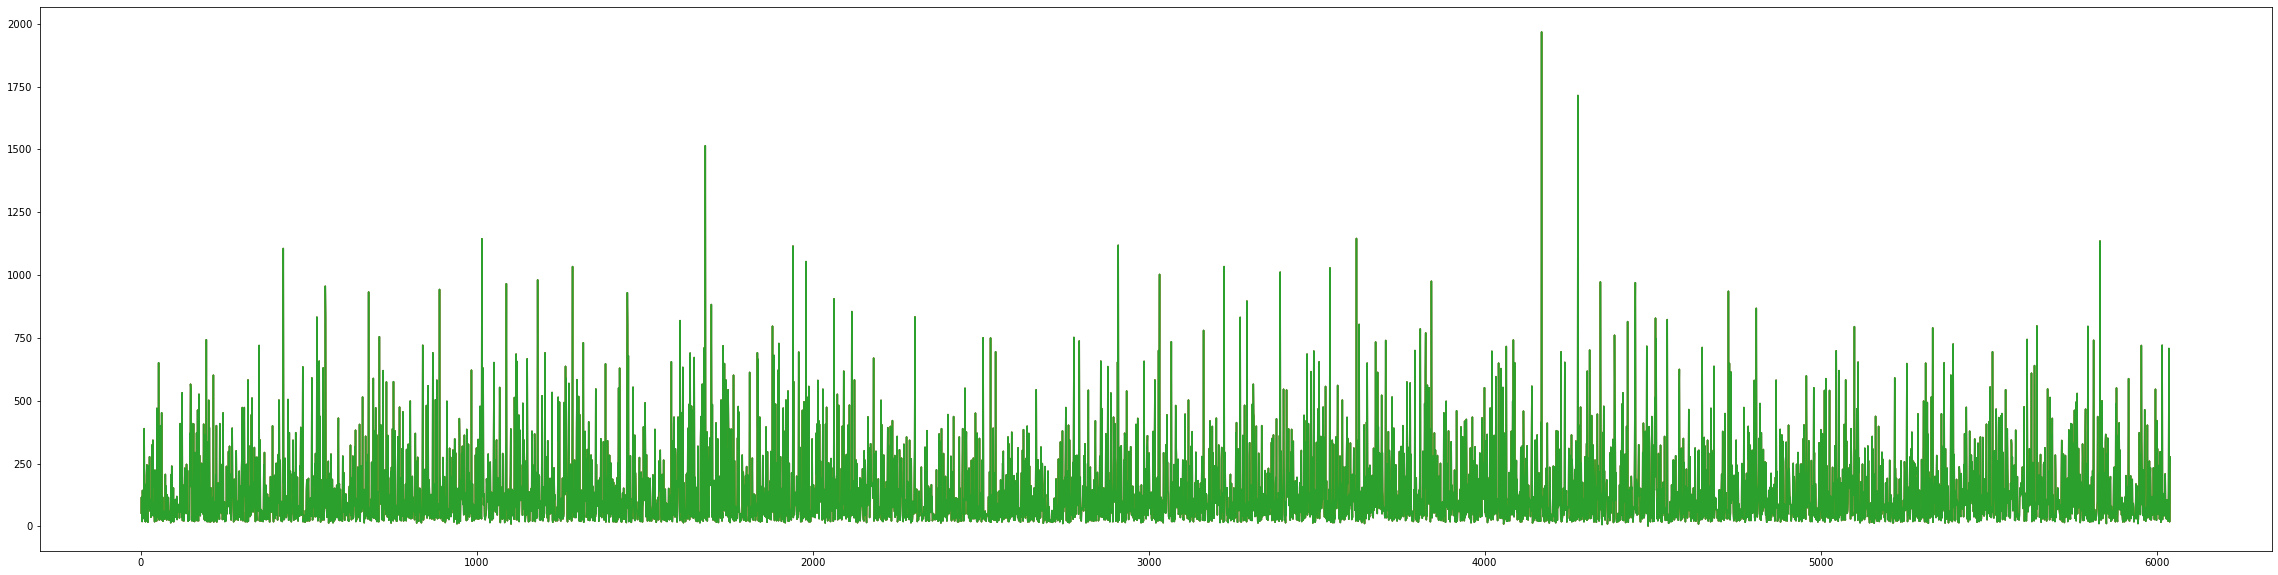

In [37]:
plt.figure(figsize=[40, 10])
plt.plot(data.groupby('UserId').count())

**train 분포**

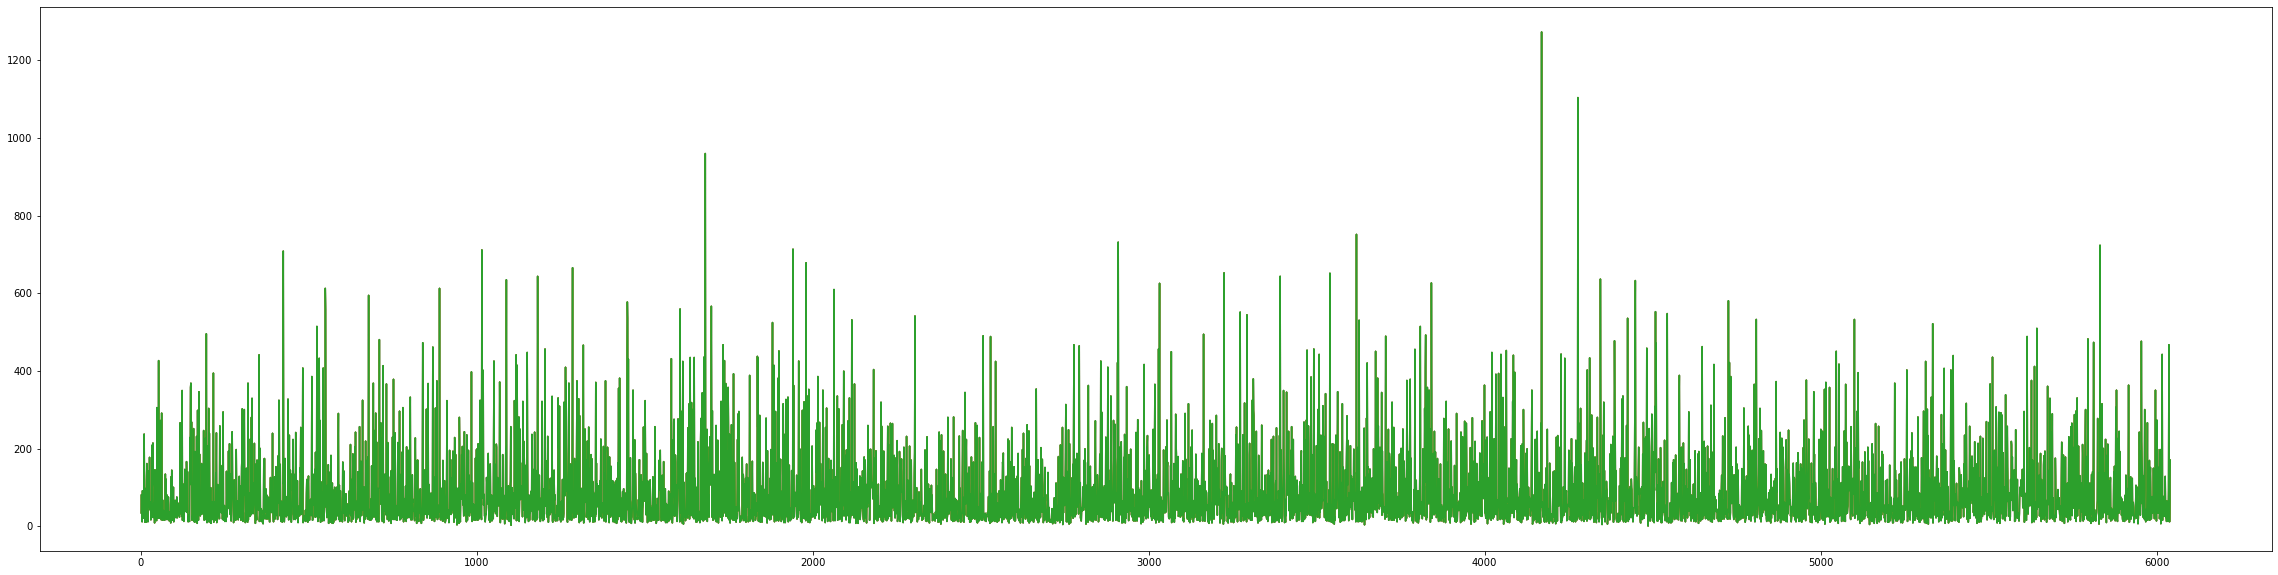

In [38]:
plt.figure(figsize=[40, 10])
plt.plot(train.groupby('UserId').count())

**validation 분포**

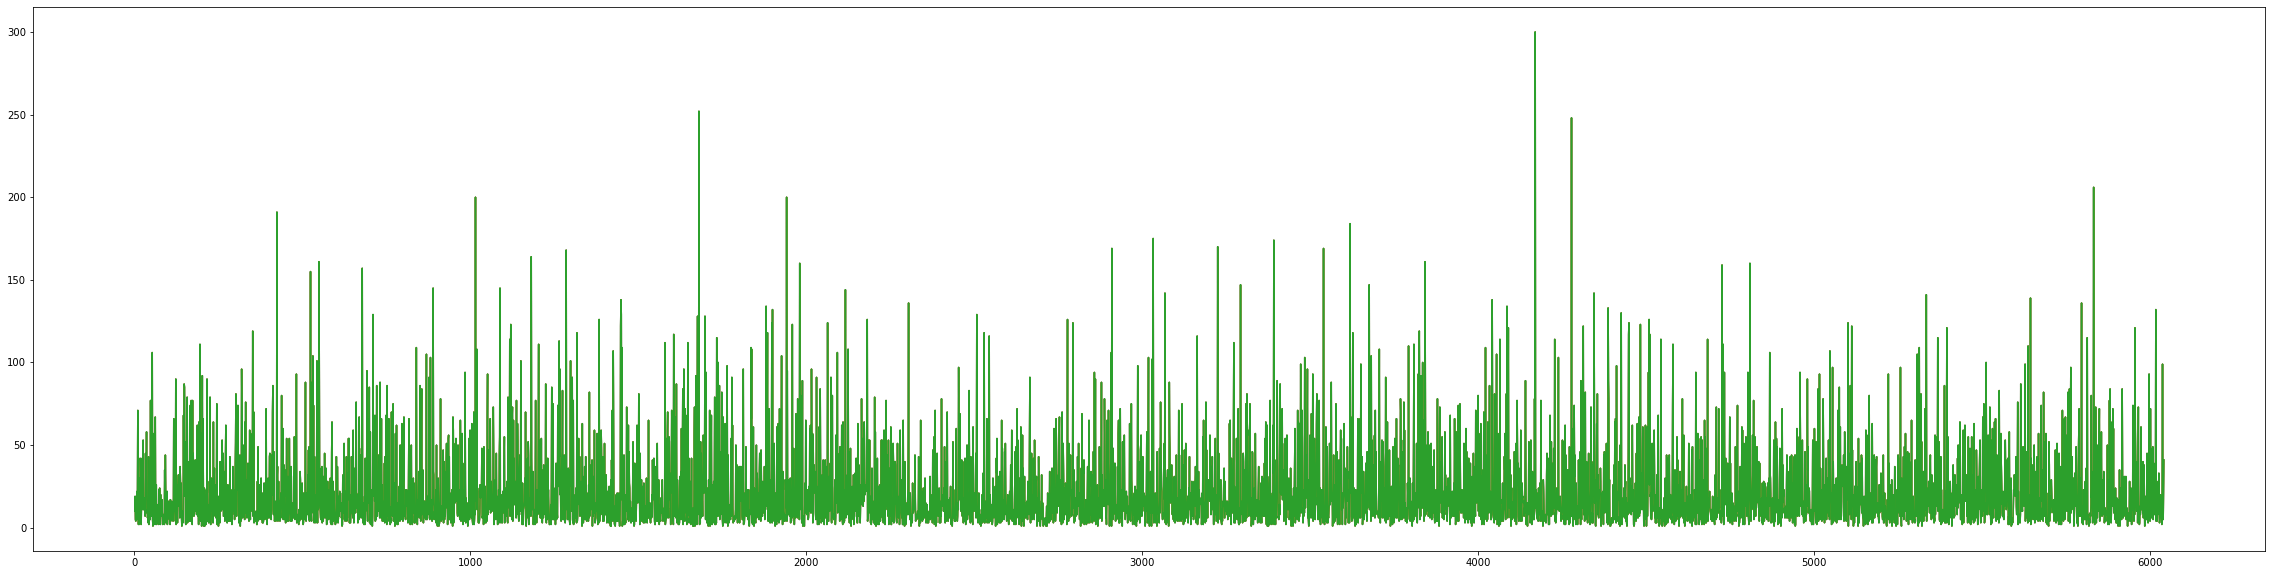

In [40]:
plt.figure(figsize=[40, 10])
plt.plot(valid.groupby('UserId').count())

**test 분포**

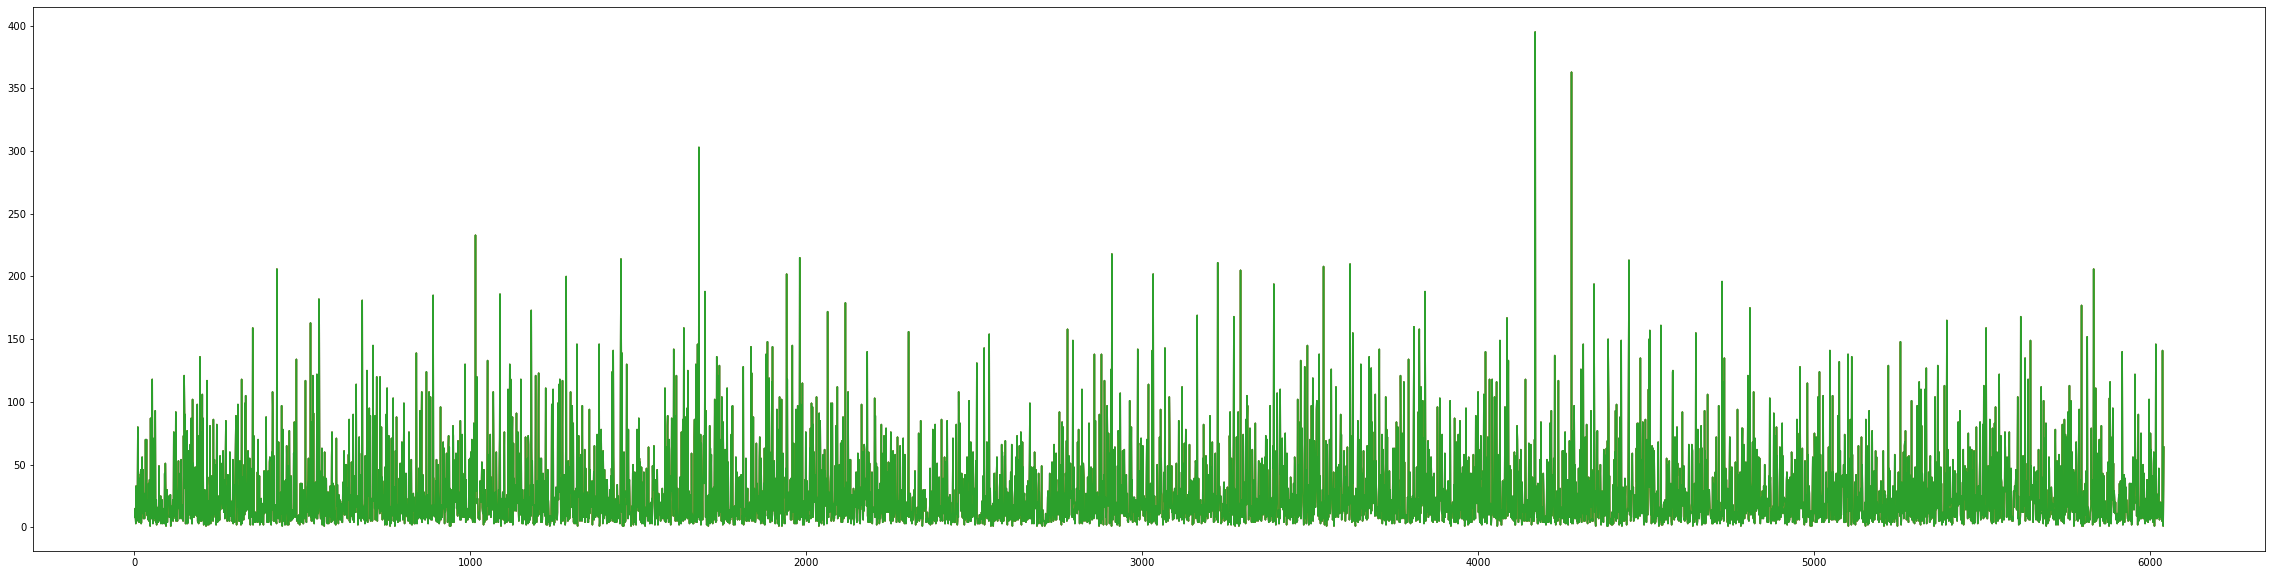

In [41]:
plt.figure(figsize=[40, 10])
plt.plot(test[:-1].groupby('UserId').count())

In [231]:
valid
[:-1].groupby('UserId').count().describe()

,ItemId,Rating,Time
count,6023.000000,6023.000000,6023.000000
mean,25.078034,25.078034,25.078034
std,29.334094,29.334094,29.334094
min,1.000000,1.000000,1.000000
25%,7.000000,7.000000,7.000000
50%,14.000000,14.000000,14.000000
75%,32.000000,32.000000,32.000000
max,366.000000,366.000000,366.000000


In [232]:
test[:-1].groupby('UserId').count().describe()

,ItemId,Rating,Time
count,6027.000000,6027.000000,6027.000000
mean,31.326697,31.326697,31.326697
std,36.323197,36.323197,36.323197
min,1.000000,1.000000,1.000000
25%,8.000000,8.000000,8.000000
50%,18.000000,18.000000,18.000000
75%,39.000000,39.000000,39.000000
max,447.000000,447.000000,447.000000


## 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

## 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

## 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

# 루브릭 평가
---
1. **Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.**   

    - 데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.


2. **RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.**

    - 적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.
     
     
3. **세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.** 

    - 3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.

    
    
# 회고
---
## 어려웠던 점 
- 구현은 했지만, SRGAN 아키텍쳐에 대한 상세한 이해가 필요할 것 같습니다. 
    
## 알게된 점 
- 해상도 변환을 GAN으로 생성하는 방법에 대해 알 수 있었습니다. 

## 다짐
- 시간적인 문제로 보다 다양한 데이터에 대한 실험을 하지 못한 것이 아쉬웠던 프로젝트입니다. 보통 제공되는 데이터는 어느정도의 결과를 얻을 수 있는 좋은 데이터이기 때문에, 실제 다양한 데이터로 실험을 해야 강건성에 대한 평가를 할 수 있습니다. 사전학습된 모델을 사용하면 정말 빠른 시간내에 결과를 얻을 수 있다는 것을 알았고, 다량의 데이터와 컴퓨팅 파워의 중요성을 느꼈습니다. 또한 결과를 단지 사람 눈으로만 평가해야한다는 것이 아쉽기도 했습니다. 실제로 gif의 경우엔 제 눈에는 bicubic으로 고화질 변환한 이미지가 원본 저화질 이미지보다 화질이 떨어지게 느껴졌는데, 객관적인 지표가 없어 정확한 평가가 어려웠습니다.